In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# Customer Lifetime Value Overview

__What is a Customer Lifetime Value (CLV)?__ Customer Lifetime Value is a monetary value that represents the amount of revenue or profit a customer will give the company over the period of the relationship. CLV demonstrates the implications of acquiring long-term customers compare to short-term customers.

__Customer Value__ = Average Order Value * Purchase Frequency

__CLV__ = (Customer Value/Churn Rate) x Profit margin.

__What is an Average Order Value(AOV)?__ The Average Order value is the ratio of your total revenue and the total number of orders. AOV represents the mean amount of revenue that the customer spends on an order. Average Order Value = Total Revenue / Total Number of Orders

__What is a Purchase Frequency(PF)?__ Purchase Frequency is the ratio of the total number of orders and the total number of customer. It represents the average number of orders placed by each customer. Purchase Frequency = Total Number of Orders / Total Number of Customers

__What is a Churn Rate?__ Churn Rate is the percentage of customers who have not ordered again.

__What is a Customer Lifetime?__ Customer Lifetime is the period of time that the customer has been continuously ordering. Customer Lifetime = 1 / Churn Rate

__What is a Repeat Rate?__ Repeat rate can be defined as the ratio of the number of customers with more than one order to the number of unique customers. Example: If you have 10 customers in a month out of who 4 come back, your repeat rate is 40%. 

__Repeat Rate__ = 1 - Churn Rate

# Loading Dataset

In [2]:
data = pd.read_csv('Customer_dataset.csv', encoding='ISO-8859-1', header=0)

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


## Removing Duplicates

In [4]:
filtered_data=data[['Country','CustomerID']].drop_duplicates()

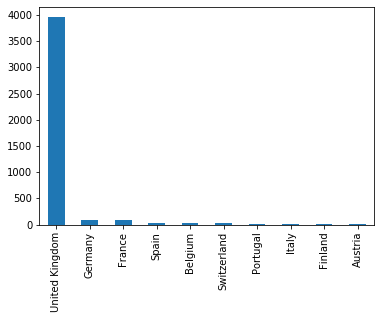

In [5]:
filtered_data.Country.value_counts()[:10].plot(kind='bar')

In [6]:
uk_data=data[data.Country=='United Kingdom']
uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495478 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      495478 non-null object
StockCode      495478 non-null object
Description    494024 non-null object
Quantity       495478 non-null int64
InvoiceDate    495478 non-null object
UnitPrice      495478 non-null float64
CustomerID     361878 non-null float64
Country        495478 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 34.0+ MB


In [7]:
uk_data.describe()

,Quantity,UnitPrice,CustomerID
count,495478.000000,495478.000000,361878.000000
mean,8.605486,4.532422,15547.871368
std,227.588756,99.315438,1594.402590
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.100000,15514.000000
75%,10.000000,4.130000,16931.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
uk_data = uk_data[(uk_data['Quantity']>0)]
uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486286 entries, 0 to 541893
Data columns (total 8 columns):
InvoiceNo      486286 non-null object
StockCode      486286 non-null object
Description    485694 non-null object
Quantity       486286 non-null int64
InvoiceDate    486286 non-null object
UnitPrice      486286 non-null float64
CustomerID     354345 non-null float64
Country        486286 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.4+ MB


## Filter required Columns

In [9]:
uk_data=uk_data[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]

In [10]:
uk_data['InvoiceDate']=pd.to_datetime(uk_data['InvoiceDate'])

In [11]:
# Calulate total purchase
uk_data['TotalPurchase'] = uk_data['Quantity'] * uk_data['UnitPrice']

In [12]:
uk_data_group=uk_data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (date.max() - date.min()).days,\
                                                 'InvoiceNo': lambda num: len(num),\
                                                 'Quantity': lambda quant: quant.sum(),\
                                                 'TotalPurchase': lambda price: price.sum()})

In [13]:
uk_data_group.head()

,InvoiceDate,InvoiceNo,Quantity,TotalPurchase
CustomerID,,,,
12346.0,0,1,74215,77183.60
12747.0,554,103,1275,4196.01
12748.0,692,4596,25748,33719.73
12749.0,312,199,1471,4090.88
12820.0,282,59,722,942.34


## Rename the column

In [14]:
# Change the name of columns
uk_data_group.columns=['num_days','num_transactions','num_units','spent_money']
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money
CustomerID,,,,
12346.0,0,1,74215,77183.60
12747.0,554,103,1275,4196.01
12748.0,692,4596,25748,33719.73
12749.0,312,199,1471,4090.88
12820.0,282,59,722,942.34


# Calculate CLTV using following formula:

CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.

Customer Value = Average Order Value * Purchase Frequency

### Calculate Average Order Value

In [15]:
# Average Order Value
uk_data_group['avg_order_value']=uk_data_group['spent_money']/uk_data_group['num_transactions']

In [16]:
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value
CustomerID,,,,,
12346.0,0,1,74215,77183.60,77183.600000
12747.0,554,103,1275,4196.01,40.737961
12748.0,692,4596,25748,33719.73,7.336756
12749.0,312,199,1471,4090.88,20.557186
12820.0,282,59,722,942.34,15.971864


### Calculate Purchase Frequency

In [17]:
purchase_frequency=sum(uk_data_group['num_transactions'])/uk_data_group.shape[0]

### Calculate Repeat Rate and Churn Rate

In [18]:
# Repeat Rate
repeat_rate=uk_data_group[uk_data_group.num_transactions > 1].shape[0]/uk_data_group.shape[0]

In [19]:
# Churn Rate
churn_rate=1-repeat_rate

In [20]:
purchase_frequency,repeat_rate,churn_rate

(90.37107880642694, 0.9818923743942872, 0.018107625605712774)

### Calculate Profit Margin

In [21]:
# Profit Margin
margin=0.05
uk_data_group['profit_margin']=uk_data_group['spent_money']*margin

In [22]:
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin
CustomerID,,,,,,
12346.0,0,1,74215,77183.60,77183.600000,3859.1800
12747.0,554,103,1275,4196.01,40.737961,209.8005
12748.0,692,4596,25748,33719.73,7.336756,1685.9865
12749.0,312,199,1471,4090.88,20.557186,204.5440
12820.0,282,59,722,942.34,15.971864,47.1170


### Calcualte Customer Lifetime Value

In [23]:
# Customer Value
uk_data_group['CLV']=(uk_data_group['avg_order_value']*purchase_frequency)/churn_rate

In [24]:
# Customer Lifetime Value
uk_data_group['customer_lifetime_value']=uk_data_group['CLV']*uk_data_group['profit_margin']

In [25]:
uk_data_group.head()

,num_days,num_transactions,num_units,spent_money,avg_order_value,profit_margin,CLV,customer_lifetime_value
CustomerID,,,,,,,,
12346.0,0,1,74215,77183.60,77183.600000,3859.1800,3.852060e+08,1.486579e+12
12747.0,554,103,1275,4196.01,40.737961,209.8005,2.033140e+05,4.265538e+07
12748.0,692,4596,25748,33719.73,7.336756,1685.9865,3.661610e+04,6.173424e+07
12749.0,312,199,1471,4090.88,20.557186,204.5440,1.025963e+05,2.098545e+07
12820.0,282,59,722,942.34,15.971864,47.1170,7.971198e+04,3.755789e+06


# Prediction Model for CLTV

In [26]:
uk_data.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPurchase
0,17850.0,2010-01-12 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-01-12 08:26:00,536365,6,3.39,20.34
2,17850.0,2010-01-12 08:26:00,536365,8,2.75,22.00
3,17850.0,2010-01-12 08:26:00,536365,6,3.39,20.34
4,17850.0,2010-01-12 08:26:00,536365,6,3.39,20.34


In [27]:
uk_data['month_yr'] = uk_data['InvoiceDate'].apply(lambda x: x.strftime('%b-%Y'))

In [28]:
uk_data.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPurchase,month_yr
0,17850.0,2010-01-12 08:26:00,536365,6,2.55,15.30,Jan-2010
1,17850.0,2010-01-12 08:26:00,536365,6,3.39,20.34,Jan-2010
2,17850.0,2010-01-12 08:26:00,536365,8,2.75,22.00,Jan-2010
3,17850.0,2010-01-12 08:26:00,536365,6,3.39,20.34,Jan-2010
4,17850.0,2010-01-12 08:26:00,536365,6,3.39,20.34,Jan-2010


In [29]:
sale=uk_data.pivot_table(index=['CustomerID'],columns=['month_yr'],values='TotalPurchase',aggfunc='sum',fill_value=0).reset_index()

In [30]:
sale.head()

month_yr,CustomerID,Apr-2011,Aug-2010,Aug-2011,Dec-2010,Dec-2011,Feb-2010,Feb-2011,Jan-2010,Jan-2011,...,Jun-2011,Mar-2010,Mar-2011,May-2010,May-2011,Nov-2011,Oct-2010,Oct-2011,Sep-2010,Sep-2011
0,12346.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,77183.60,...,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00
1,12747.0,675.38,0.00,301.70,347.71,0.0,0.00,0.00,0.00,613.82,...,376.30,0.0,0.00,358.56,771.31,312.73,0.00,0.00,0.0,0.00
2,12748.0,1351.54,367.52,1926.85,809.80,538.3,4.25,673.06,4.95,666.94,...,2582.56,0.0,1148.78,966.40,1407.43,11339.11,1416.98,2369.79,136.2,4113.07
3,12749.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,1896.13,...,763.06,0.0,0.00,0.00,0.00,572.59,0.00,859.10,0.0,0.00
4,12820.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,170.46,...,210.35,0.0,0.00,0.00,0.00,0.00,0.00,343.76,0.0,217.77


In [31]:
sale['CLV']=sale.iloc[:,2:].sum(axis=1)

In [32]:
sale.head()

month_yr,CustomerID,Apr-2011,Aug-2010,Aug-2011,Dec-2010,Dec-2011,Feb-2010,Feb-2011,Jan-2010,Jan-2011,...,Mar-2010,Mar-2011,May-2010,May-2011,Nov-2011,Oct-2010,Oct-2011,Sep-2010,Sep-2011,CLV
0,12346.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,77183.60,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,77183.60
1,12747.0,675.38,0.00,301.70,347.71,0.0,0.00,0.00,0.00,613.82,...,0.0,0.00,358.56,771.31,312.73,0.00,0.00,0.0,0.00,3520.63
2,12748.0,1351.54,367.52,1926.85,809.80,538.3,4.25,673.06,4.95,666.94,...,0.0,1148.78,966.40,1407.43,11339.11,1416.98,2369.79,136.2,4113.07,32368.19
3,12749.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,1896.13,...,0.0,0.00,0.00,0.00,572.59,0.00,859.10,0.0,0.00,4090.88
4,12820.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,170.46,...,0.0,0.00,0.00,0.00,0.00,0.00,343.76,0.0,217.77,942.34


## Selecting Feature

In [33]:
X=sale[['Dec-2011','Nov-2011', 'Oct-2011','Sep-2011','Aug-2011','Jul-2011']]
y=sale[['CLV']]

## Splitting Data

In [34]:
# split training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

## Model Development

In [35]:
# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

In [36]:
# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

[154.77773688]
[[1.776394   1.25780005 1.29552681 1.02716594 2.03078772 3.08574343]]


## How Well Does the Model Fit the data?

In [37]:
# compute the R Square for model
print("R-Square:",metrics.r2_score(y_test, y_pred))

R-Square: 0.9583812921944286


## Model Evaluation

__Mean Absolute Error (MAE)__ is the mean of the absolute value of the errors.

__Mean Squared Error (MSE)__ is the mean of the squared errors.

__Root Mean Squared Error (RMSE)__ is the square root of the mean of the squared

In [38]:
# calculate MAE using scikit-learn
print("MAE:",metrics.mean_absolute_error(y_test,y_pred))
#calculate mean squared error
print("MSE",metrics.mean_squared_error(y_test, y_pred))
# compute the RMSE of our predictions
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 632.2443475991834
MSE 2557738.5628728596
RMSE: 1599.2931447589149
